# 영화 리뷰 분류 : 이진 분류 예제
* IMDB 데이터 셋을 영화 리뷰 긍정 & 부정으로 분류 한다.
***

## 1. IMBD 데이터셋 로드

In [2]:
from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

> __num_words=10000__ 은 훈련 데이터에서 가장 자주 나타나는 단어 1만개를 사용하겠다는 뜻이다.   

* train_data, test_data : 리뷰의 목록으로 각 리뷰는 단어 인덱스의 리스트이다.
* train_labels, test_labels : __부정__ 을 나타내는 0과 __긍정__ 을 나타내는 1의 리스트이다.

## 2. 데이터 준비
> 신경망에 숫자 __리스트__ 를 주입할 수 는 없다. 리스트를 텐서로 바꾸는 두가지 방법이 있다.

* 같은 길이가 되게 리스트에 패딩을 추가하고 (samples, sequence_length)크기의 정수 텐서로 변환, 그 다음 이 정수 텐서를 다룰 수 있는 층을 신경망의 첫 번째 층으로 사용한다.
* 리스트를 원-핫 인코딩하여 0과 1의 벡터로 변환, 부동 소수 벡터 데이터를 다룰 수 있는 __Dense__ 층을 신경망의 첫번째 층으로 사용한다.
> 두번째 방식을 이용한다

In [15]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))  # 크기가 (len(sequences), dimension)이고 모든 원소가 0인 행렬을 만든다
    for i, sequence in enumerate(sequences) :
        results[i, sequence] = 1.                    # results[i]에서 특정 인덱스의 위치를 1로 만든다
    return results

x_train = vectorize_sequences(train_data)           # 훈련 데이터를 벡터로 변환
x_test = vectorize_sequences(test_data)             # 테스트 데이터를 벡터로 변환합니다

In [4]:
# 레이블도 벡터로 변환

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

## 3. 신경망 모델 만들기

> 입력 데이터가 벡터고 레이블은 스칼라(1 or 0)이다. 

* 이 문제에 맞는 네트워크 종류는 __relu__ 활성화 함수를 사용한 완전 연결 층(즉 Dense(16, activation='relu'))을 쌓은것
    > Dense층에 전달한 매개변수(16)은 은닉 유닛의 개수이다.

#### Dense 층을 쌓을 때 두가지 중요한 구조상의 결정이 필요하다.
* 얼마나 많은 층을 사용할 것인가?
* 각 층에 얼마나 많은 은닉 유닛을 둘 것인가?

### 활성화 함수 결정
* 중간 은닉 층 : relu를 활성화 함수로 사용한다
* 마지막 층 : 1~0 사이의 점수로 확률을 울력하기 위해 시그모이드를 활성화 함수로 사용한다.

In [5]:
from keras import models
from keras import layers

model = models.Sequential() # Sequential(순차모델) : 순차적으로 레이어 층을 더해 모델을 만든다
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

### 손실 함수와 옵티마이저
> 이진 분류 문제에 출력이 확률이기 때문에 __binary_crossentropy(또는 mean_squared_error)__ 손실이 적합하다

* __확률을 출력하는 모델은 솔실 함수로 크로스 엔트로피가 최선이다__ 
* __크로스엔트로피__ : 정보 이론 분야에서 온 개념으로 확률 분포 간의 차이를 측정한다.(원본 분포와 예측 분포 사이를 측정한다)

> 옵티마이저 : rmsprop

In [6]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy']) # 측정 지표

## 4. 훈련 검증
* 훈련동안 처음 본 데이터에 대한 모델의 정확도를 측정하기 위해 원본 훈련 데이터에서 10000개의 샘플을 떼어 검증 세트를 만든다.

In [7]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]
y_val = y_train[:10000]
partial_y_train = y_train[10000:]

* 모델을 512개의 샘플씩 미니 배치를 만들어 20번의 __에포크(x_train과 y_train 텐서에 있는 모든 샘플에 대해 20번 반복)__ 동안 훈련시킨다

* 따로 떼어 놓은 1만 개의 샘플에서 __손실과 정확도__ 를 측정할 것. 이러기 위해서는 __validation_data__ 매개변수에 검증 데이터를 전달해야함


In [8]:
model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['acc'])  # accuracy와 동일
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data=(x_val, y_val)) # 손실과 정확도 측정을 위해 검증 데이터 제공

Epoch 1/20
30/30 [==============================] - 3s 91ms/step - loss: 0.5012 - acc: 0.7922 - val_loss: 0.3811 - val_acc: 0.8598
Epoch 2/20
30/30 [==============================] - 2s 51ms/step - loss: 0.2984 - acc: 0.9007 - val_loss: 0.2968 - val_acc: 0.8892
Epoch 3/20
30/30 [==============================] - 1s 33ms/step - loss: 0.2153 - acc: 0.9329 - val_loss: 0.2784 - val_acc: 0.8924
Epoch 4/20
30/30 [==============================] - 1s 46ms/step - loss: 0.1718 - acc: 0.9430 - val_loss: 0.2771 - val_acc: 0.8892
Epoch 5/20
30/30 [==============================] - 1s 31ms/step - loss: 0.1422 - acc: 0.9522 - val_loss: 0.2831 - val_acc: 0.8890
Epoch 6/20
30/30 [==============================] - 1s 30ms/step - loss: 0.1130 - acc: 0.9658 - val_loss: 0.3309 - val_acc: 0.8739
Epoch 7/20
30/30 [==============================] - 1s 33ms/step - loss: 0.0961 - acc: 0.9711 - val_loss: 0.3224 - val_acc: 0.8832
Epoch 8/20
30/30 [==============================] - 1s 29ms/step - loss: 0.0787 - a

* model.fit() 메서드는 __History 객체__ 를 반환한다. 이 객체는 __훈련하는 동안 발생한 모든 정보를 담고 있는 딕셔너리__ 인 history 속성을 가지고 있다

In [9]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

* 훈련과 검증 손실 그리기

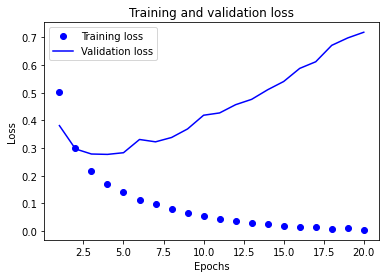

In [10]:
import matplotlib.pyplot as plt

history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss') # 'bo'는 파란점을 의미
plt.plot(epochs, val_loss, 'b', label='Validation loss') # 'b'는 파란색 실선을 의미
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

* 훈련과 검증 정확도 그리기

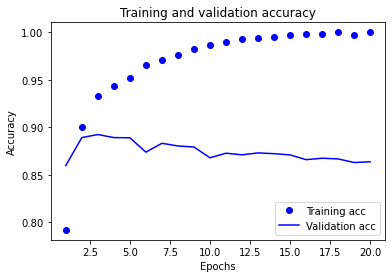

In [13]:
plt.clf()  # 그래프 초기화
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

* 데이터가 __과대적합__ 되어서 두번째 epochs 이후로 훈련 데이터에 과도하게 최적화 되어 다른 데이터에는 일반화 되지 못했다.
* 다시 새로운 신경망을 네번의 epochs동안만 훈련하고 테스트 데이터에서 평가한다.
> fit()메서드를 재호출하면 학습된 가중치에서 이어지므로 처음부터 다시 학습할려면 모델 객체를 다시 만들어야한다.

In [18]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
print(results)

Epoch 1/4
49/49 [==============================] - 1s 21ms/step - loss: 0.4716 - accuracy: 0.8086
Epoch 2/4
49/49 [==============================] - 1s 21ms/step - loss: 0.2698 - accuracy: 0.9082
Epoch 3/4
49/49 [==============================] - 1s 20ms/step - loss: 0.2045 - accuracy: 0.9292
Epoch 4/4
782/782 [==============================] - 1s 2ms/step - loss: 0.3064 - accuracy: 0.8781
[0.30637720227241516, 0.8781200051307678]


## 훈련된 모델로 새로운 데이터에 대해 예측하기
* predict 메서드로 어떤 리뷰가 긍정일 확률을 예측 가능하다.

In [19]:
model.predict(x_test)

array([[0.14816839],
       [0.99994653],
       [0.87214017],
       ...,
       [0.1221042 ],
       [0.06128135],
       [0.5331974 ]], dtype=float32)

## 결론
* 원본 데이터를 신경망에 __텐서__ 로 주입하기 위해서는 꽤 많은 전처리가 필요하다.(단어 시퀀스는 이진 벡터로 인코딩 될 수 있고 다른 인코딩 방식도 있다)
* __relu__ 활성화 함수와 함께 Dense층을 샇은 네트어크는 여러 문제에 적용 가능하다.
* __이진 분류 문제에서 네트워크는 하나의 유닛과 sigmoid 활성화 함수를 가진 Dense 층으로 끝나야 한다.(이 신경망의 출력은 확률을 나타내는 0과 1 사이의 스칼라 값이다.)__
* __이진 분류 문제에서 이런 스칼라 시그모이드 출력에 대해 사용할 손실 함수는 binary_crossentropy이다.__
* __rmsprop__ 옵티마이저는 문제에 상관없이 일반적으로 충분히 좋은 선택이다.
* 훈련 데이터에 대해 성능이 향상됨에 따라 과대적합되기 시작하기에 항상 훈련 세트 이외의 데이터에서 성능을 모니터링해야한다.